# Analyze eye signal data

created: November 19, 2024 <br>
last modified:  February 28, 2024

Start by analyzing a downsampled version of eye data, then introduce full resolution eye data and compare resting state aperiodic activity in eyes open vs close and in specific timepoint when eyes closed become open (or viceversa)

In [89]:
# Imports
import neo
import numpy as np
import pandas as pd
import quantities as pq
import matplotlib.pyplot as plt
from mne.time_frequency import psd_array_multitaper
from neurodsp.spectral import compute_spectrum
from specparam import SpectralModel

# custom
import sys
sys.path.append("../../code")
from info import FS
from settings import N_JOBS
from paths import EXTERNAL_PATH, PROJECT_PATH
from utils import load_nix, epoch_neo_segment

In [2]:
# set path
eye_path = EXTERNAL_PATH + "/V1_v4_1024_electrode_resting_state_data/data/L_RS_090817/eye_signals/"

lfp_path = EXTERNAL_PATH + "/V1_v4_1024_electrode_resting_state_data/data/L_RS_090817/LFP/"

### Analyze eye data
Create new nix file containing behavioral states

In [17]:
# Load data
with neo.NixIO(eye_path + "aligned_eye_data.nix", mode='ro') as nio:
    eye_block = nio.read_block()

eye_block

Block with 1 segments
name: 'Eye signals'
description: 'eye position and diameters'
annotations: {'nix_name': 'neo.block.4296992d060d4ee7b15db59fadc15740'}
file_datetime: datetime.datetime(2021, 4, 19, 13, 5, 17, 913450)
rec_datetime: datetime.datetime(2021, 4, 19, 6, 25, 32)
# segments (N=1)
0: Segment with 4 analogsignals, 1 epochs
   name: 'eye signal segment'
   description: 'Segment of eye pos and diam'
   annotations: {'nix_name': 'neo.segment.c532f30c3a734eabae2418c49282dada'}
   # analogsignals (N=4)
   0: AnalogSignal with 1 channels of length 39627730; units mV; datatype int16 
      name: 'XPos'
      annotations: {'nix_name': 'neo.analogsignal.19582fa74cef491f8a907698b6ad6702'}
      sampling rate: 30000.0 Hz
      time: 0.0 s to 1320.9243333333334 s
   1: AnalogSignal with 1 channels of length 39627730; units mV; datatype int16 
      name: 'YPos'
      annotations: {'nix_name': 'neo.analogsignal.62564a856339447fa99eb204ee0daddc'}
      sampling rate: 30000.0 Hz
      time

In [18]:
# set datetime to None to avoid errors when saving
# Neo Github issue: https://github.com/NeuralEnsemble/python-neo/issues/1198

print(f"Original datetime: {eye_block.rec_datetime}")

# set block and segment datetime to None
eye_block.rec_datetime = None
for segment in eye_block.segments:
    segment.rec_datetime = None

print(f"New datetime: {eye_block.rec_datetime}")


Original datetime: 2021-04-19 06:25:32
New datetime: None


In [19]:
# access X and Y pupil diameter
xdiam = eye_block.segments[0].analogsignals[2] / 1000
ydiam = eye_block.segments[0].analogsignals[3] / 1000
xdiam[xdiam < 0] = 0*pq.mV
ydiam[ydiam < 0] = 0*pq.mV

# we use .magnitude to access values
diam = np.sqrt(ydiam.magnitude**2 + xdiam.magnitude**2)
print(f"pupil diameter for every time point: {diam.shape}")

pupil diameter for every time point: (39627730, 1)


In [20]:
### Estimate behavioural epochs

# Empirically estimated thresholds for eye closure, according to Chen et al
#   if 'L_RS_090817' in eye_path: thr = 0.101
mask = (diam > 0.101)
behavioral_state = mask.astype(float)[:, 0]

# Smoothen states with sliding window
w = 3
kernel = [1/w]*w
behavioral_state = np.convolve(behavioral_state, kernel, mode='same')
behavioral_state[behavioral_state < 0.5] = 0
behavioral_state[behavioral_state >= 0.5] = 1

# Save signal to block
behaviour_anasig = neo.core.AnalogSignal(behavioral_state,
                                              units=pq.V,
                                              sampling_rate=xdiam.sampling_rate,
                                              name='Behavioural state')
eye_block.segments[0].analogsignals.append(behaviour_anasig)

In [7]:
unique, counts = np.unique(behavioral_state, return_counts=True)
print(f"Eyes open or closed measured in binary: {unique} \neyes closed: {counts[0]} \neyes open:{counts[1]}")

Eyes open or closed measured in binary: [0. 1.] 
eyes closed: 32473667 
eyes open:7154063


In [ ]:
# confirm that we have 5 analogsignals (our 4 original + behaviour)
eye_block.segments[0]

Segment with 5 analogsignals, 1 epochs
name: 'eye signal segment'
description: 'Segment of eye pos and diam'
annotations: {'nix_name': 'neo.segment.c532f30c3a734eabae2418c49282dada'}
# analogsignals (N=5)
0: AnalogSignal with 1 channels of length 39627730; units mV; datatype int16 
   name: 'XPos'
   annotations: {'nix_name': 'neo.analogsignal.19582fa74cef491f8a907698b6ad6702'}
   sampling rate: 30000.0 Hz
   time: 0.0 s to 1320.9243333333334 s
1: AnalogSignal with 1 channels of length 39627730; units mV; datatype int16 
   name: 'YPos'
   annotations: {'nix_name': 'neo.analogsignal.62564a856339447fa99eb204ee0daddc'}
   sampling rate: 30000.0 Hz
   time: 0.0 s to 1320.9243333333334 s
2: AnalogSignal with 1 channels of length 39627730; units mV; datatype int16 
   name: 'XDiam'
   annotations: {'nix_name': 'neo.analogsignal.6ec6601136fb4b00be8f79bbf5e4ad78'}
   sampling rate: 30000.0 Hz
   time: 0.0 s to 1320.9243333333334 s
3: AnalogSignal with 1 channels of length 39627730; units mV; 

In [25]:
# save file 
with neo.io.NixIO(eye_path + "L_RS_090817_aligned_eye_data.nix", mode='ow') as nio:
    nio.write_block(eye_block)

print(f"Block saved to {eye_path}L_RS_090817_aligned_eye_data.nix")

Block saved to E:/V1_v4_1024_electrode_resting_state_data/data/L_RS_090817/eye_signals/L_RS_090817_aligned_eye_data.nix


### Define time windows and load LFP data

In [9]:
# load LFP and eye data 
fname = lfp_path + "NSP1_array1_LFP.nix"
lfp_segment, _ = load_nix(fname)
lfp_signal = lfp_segment.analogsignals[0]

with neo.io.NixIO(eye_path + "L_RS_090817_aligned_eye_data.nix", mode='ro') as nio:
    eye_block = nio.read_block()
eye_signal = eye_block.segments[0].analogsignals[4]

# # downsample eye signals to fit LFP
# downsample_factor = int(pre_eye_signal.sampling_rate.magnitude / lfp_signal.sampling_rate.magnitude)
# if downsample_factor == 60 :
#     eye_signal = pre_eye_signal.downsample(downsample_factor)

# if len(eye_signal) == len(lfp_signal):
#     print(f"Total values in signal: {len(lfp_signal)}")

In [10]:
print(f"Segment duration: {lfp_segment.t_start} to {lfp_segment.t_stop}")

Segment duration: 0.0 s to 1320.926 s


In [11]:
# time indices where there is a change from eyes open to eyes closed
eye_array = eye_signal.magnitude.flatten()
wh = np.where(np.diff(eye_array) != 0)[0]
print(f"Number of changes in behavioral states: {wh.shape[0]} \nTotal time points: {eye_array.shape[0]}")

Number of changes in behavioral states: 1102 
Total time points: 39627730


In [ ]:
# find instances where the eyes are open/closed for Xsec duration and then Xsec of the other state
DURATION_TIMES = np.arange(0.5,6.5,0.5)

instances = np.array([])

for t in DURATION_TIMES:
    DURATION = t # in seconds 

    differences = np.diff(wh)
    epoch_indices = np.array([])
    for i in range(0, len(differences)):
        if (differences[i] >= DURATION*30000) & (differences[i-1] >= DURATION*30000):
            epoch_indices = np.append(epoch_indices, wh[i])

    instances = np.append(instances, epoch_indices.shape[0])

    print(f"Number of changes in behavioral states with {DURATION} seconds: {epoch_indices.shape[0]}")
        

Number of changes in behavioral states with 0.5 seconds: 64
Number of changes in behavioral states with 1.0 seconds: 31
Number of changes in behavioral states with 1.5 seconds: 14
Number of changes in behavioral states with 2.0 seconds: 11
Number of changes in behavioral states with 2.5 seconds: 7
Number of changes in behavioral states with 3.0 seconds: 4
Number of changes in behavioral states with 3.5 seconds: 2
Number of changes in behavioral states with 4.0 seconds: 2
Number of changes in behavioral states with 4.5 seconds: 0
Number of changes in behavioral states with 5.0 seconds: 0
Number of changes in behavioral states with 5.5 seconds: 0
Number of changes in behavioral states with 6.0 seconds: 0


Text(0, 0.5, 'Number of changes in behavior')

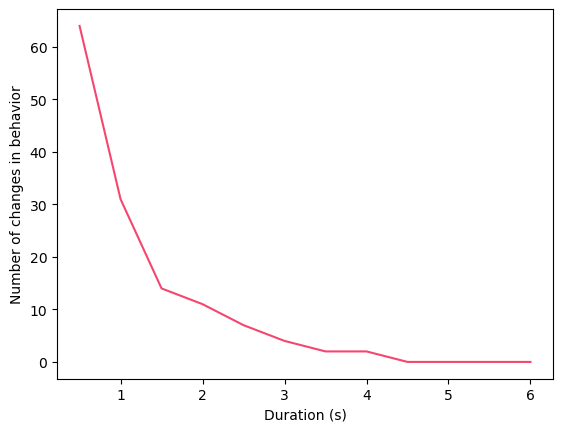

In [74]:

# plot function of change between set duration of behavioral state and number of changes in behavior for 1 RS session
fig, ax = plt.subplots()

ax.plot(DURATION_TIMES, instances, color="#F5466F")
ax.set_xlabel("Duration (s)")
ax.set_ylabel("Number of changes in behavior")
#ax.show()

### Epoch transition times

Create a CSV file containing all time windows where there is a 2 second period of eyes in state 1 (either open or closed) and a 2 second transition in state 2

In [12]:
# define duration of our window as 2 seconds
## this gives us 11 instances of behavioral change for 1 RS session of monkey L

DURATION = 2 #seconds
differences = np.diff(wh)
epoch_indices = np.array([])
for i in range(0, len(differences)):
    if (differences[i] >= DURATION*30000) & (differences[i-1] >= DURATION*30000):
        epoch_indices = np.append(epoch_indices, wh[i])

print(f"Number of changes in behavioral states with {DURATION} seconds: {epoch_indices.shape[0]}")

Number of changes in behavioral states with 2 seconds: 11


In [13]:
# create time stamps from indices
time = np.array(eye_signal.times)
epoch_times = np.array([])

for i in epoch_indices:
    timestamp = time[int(i)]
    epoch_times = np.append(epoch_times, timestamp)

epoch_times

array([ 289.16013333,  293.30373333,  296.10043333,  322.9545    ,
        354.903     ,  381.4944    ,  538.64663333,  885.7171    ,
       1120.32023333, 1164.14456667, 1225.85996667])

In [78]:
# use time stamps for epoching
transition_times = pd.DataFrame(dtype=object)

signal_epoch = []
signal_time = []
behavior_start = []
behavior_stop = []


count = 0
for sec in epoch_times:
    count += 1

    print(f"transition ocurrence #{count}")

    t_start = sec - 2
    t_stop = sec + 2

    lfp_sliced = lfp_signal.time_slice(t_start * pq.s, t_stop * pq.s)
    beh_sliced = eye_signal.time_slice(t_start * pq.s, t_stop * pq.s)

    signal_epoch.append(lfp_sliced.magnitude)
    signal_time.append(lfp_sliced.times.magnitude)

    if beh_sliced.magnitude[0] == 0:
        print(f"    initialized as eyes closed at {round(t_start,2)}")
        behavior_start.append("closed")
    elif beh_sliced.magnitude[0] == 1:
        print(f"    initialized as eyes open at {round(t_start,2)}") 
        behavior_start.append("open")
    
    if beh_sliced.magnitude[-1] == 0:
        print(f"    finalized as eyes closed at {round(t_stop,2)}")
        behavior_stop.append("closed")
    elif beh_sliced.magnitude[-1] == 1:
        print(f"    finalized as eyes open at {round(t_stop,2)}")
        behavior_stop.append("open")
    

transition_times['state_1'] = behavior_start
transition_times['state_2'] = behavior_stop
transition_times['lfp'] = signal_epoch
transition_times['time'] = signal_time

transition ocurrence #1
    initialized as eyes closed at 287.16
    finalized as eyes open at 291.16
transition ocurrence #2
    initialized as eyes open at 291.3
    finalized as eyes closed at 295.3
transition ocurrence #3
    initialized as eyes closed at 294.1
    finalized as eyes open at 298.1
transition ocurrence #4
    initialized as eyes open at 320.95
    finalized as eyes closed at 324.95
transition ocurrence #5
    initialized as eyes closed at 352.9
    finalized as eyes open at 356.9
transition ocurrence #6
    initialized as eyes open at 379.49
    finalized as eyes closed at 383.49
transition ocurrence #7
    initialized as eyes closed at 536.65
    finalized as eyes open at 540.65
transition ocurrence #8
    initialized as eyes open at 883.72
    finalized as eyes closed at 887.72
transition ocurrence #9
    initialized as eyes open at 1118.32
    finalized as eyes closed at 1122.32
transition ocurrence #10
    initialized as eyes open at 1162.14
    finalized as eyes

In [79]:
transition_times

,state_1,state_2,lfp,time
0,closed,open,"[[38.07482058688473, 30.839792736238156, 33.94...","[287.16, 287.16200000000003, 287.1640000000000..."
1,open,closed,"[[-38.49435925946981, -31.330522739270233, -26...","[291.30400000000003, 291.30600000000004, 291.3..."
2,closed,open,"[[-13.998995810034833, -4.867778710755416, 4.3...","[294.1, 294.10200000000003, 294.10400000000004..."
3,open,closed,"[[13.206796728673371, 16.882380718237453, 7.48...","[320.954, 320.956, 320.958, 320.96, 320.962, 3..."
4,closed,open,"[[24.951716453766686, 11.349755470718321, 29.0...","[352.904, 352.906, 352.908, 352.90999999999997..."
5,open,closed,"[[19.71325118204737, 33.52533660707827, 15.040...","[379.494, 379.49600000000004, 379.498000000000..."
6,closed,open,"[[49.415765024980956, 37.979291880874314, 12.5...","[536.646, 536.6479999999999, 536.65, 536.65199..."
7,open,closed,"[[9.57130154535084, 14.911264675900723, 18.119...","[883.7180000000001, 883.72, 883.7220000000001,..."
8,open,closed,"[[-40.09471336350105, -50.731377867784786, -51...","[1118.32, 1118.322, 1118.3239999999998, 1118.3..."
9,open,closed,"[[32.95809359004258, 19.346196922785218, 31.01...","[1162.144, 1162.146, 1162.148, 1162.15, 1162.1..."


In [80]:
# save dataframe to csv
transition_times.to_csv(PROJECT_PATH + "/data/results/lfp_eye_arousal.csv")

In [81]:
type(lfp_sliced.magnitude)

numpy.ndarray

### Compute spectra

calculate and plot spectra from csv

In [76]:
# load data
transition_times = pd.read_csv(PROJECT_PATH + "/data/results/lfp_eye_arousal.csv")

In [84]:
transition_times['lfp'][0]

array([[ 38.07482059,  30.83979274,  33.94191367, ...,  38.78437854,
         37.80898078,  31.10260234],
       [ 42.41193393,  32.75362263,  36.55692089, ...,  43.07328905,
         41.97401808,  34.50215498],
       [ 44.0003779 ,  35.90524987,  38.12755464, ...,  46.25818768,
         45.92447606,  37.11186815],
       ...,
       [-66.34101073, -48.61208412, -53.371726  , ..., -43.09877078,
        -54.05323863, -57.34685337],
       [-65.90433276, -46.57716112, -49.46347086, ..., -43.96329922,
        -52.89856177, -60.12001896],
       [-62.7328628 , -42.10789913, -56.77496855, ..., -43.70016399,
        -50.30757961, -59.42631566]])

In [ ]:
# compute power spectrum
freq, psd = compute_spectrum(transition_times['lfp'][0], FS)

TypeError: compute_spectrum_welch() got an unexpected keyword argument 'n_jobs'

In [94]:
# settings
BANDWIDTH = 5.0 # frequency bandwidth of multitaper decomposition
lfp = transition_times['lfp'][0]

spectra_i, freq = psd_array_multitaper(lfp, FS, n_jobs=N_JOBS,
                                                       bandwidth=BANDWIDTH,
                                                       verbose=False)

ValueError: bandwidth value 5.0 yields a normalized bandwidth of 0.32 < 0.5, use a value of at least 7.8125

In [91]:
fm = SpectralModel()
fm.add_data(freq, psd)
fm.plot()

DataError: Inputs are not the right dimensions.

### ***deprecated

In [ ]:
# downsample eye signals to fit LFP
downsample_factor = int(eye_signal.sampling_rate.magnitude / lfp_signal.sampling_rate.magnitude)
if downsample_factor == 60 :
    downsample_eye = eye_signal.downsample(downsample_factor)

True

In [ ]:
# define function for when creating the epoch object
def get_mean_state(diam):
    if np.sum(diam <= 0.5) > np.sum(diam > 0.5):
        state = 'Closed_eyes'
    else:
        state = 'Open_eyes'
    return state

In [ ]:
## create epoch object
wh = np.where(np.diff(behavioral_state) != 0)[0]
wh.shape
#start_time = wh - (duration/2)
# edgeindex = [0] + wh.tolist() + [len(behavioural_state)]

# # initialise with first slice
# i_start = [edgeindex[0]]
# i_stop = [edgeindex[1]]
# states = [get_mean_state(behavioural_state[edgeindex[0]:edgeindex[1]])]
# # Loop over indices, assign states and merge consecutive same-state slices
# for startidx, stopidx in zip(edgeindex[1:-1], edgeindex[2:]):
#     nextstate = get_mean_state(behavioural_state[startidx:stopidx])
#     if nextstate == states[-1]:
#         i_stop[-1] = stopidx
#     else:
#         i_start.append(startidx)
#         i_stop.append(stopidx)
#         states.append(nextstate)

# # Turn index lists into time arrays
# start_times = (np.array(i_start) / ydiam.sampling_rate).rescale('s')
# stop_times = (np.array(i_stop) / ydiam.sampling_rate).rescale('s')
# durs = stop_times - start_times

# # Convert into a pandas dataframe,
# datadict = {'t_start': start_times.magnitude,
#                 't_stop': stop_times.magnitude,
#                 'dur': durs.magnitude,
#                 'state': states}

# epochs = pd.DataFrame(data=datadict)

AnalogSignal with 1 channels of length 39627730; units V; datatype float64 
name: 'Behavioural state'
annotations: {'nix_name': 'neo.analogsignal.6dcd4242b0ad425ea2b787dbf5fc1357'}
sampling rate: 30000.0 Hz
time: 0.0 s to 1320.9243333333334 s